In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

In [2]:
# --- load data from years 83-07 ---

r83 = requests.get("http://web.archive.org/web/20070908142457/http://chronicle.com/stats/usnews/", headers=header)
df83 = pd.read_html(r83.text)[0]

## clean data format
data83 = df83.iloc[3:60,2:24]
cols = df83.iloc[2, 2:16].str.replace("'", "19").append(df83.iloc[2, 16:24].str.replace("'", "20"))
data83.rename(columns=cols.astype(int), index=df83.iloc[3:60, 1], inplace=True)

# --- load data from years 2011-2018 ---

r11 = requests.get("http://publicuniversityhonors.com/2016/09/18/average-u-s-news-rankings-for-126-universities-2010-1017/", \
                 headers=header)
df11 = pd.read_html(r11.text)[0]

## clean data format
data11 = df11.iloc[3:128,1:9]
data11.rename(columns=df11.iloc[0, 1:9].astype(int), index=df11.iloc[3:128, 0], inplace=True)

# --- load data from years 2008-2015 ---

r08 = requests.get("http://publicuniversityhonors.com/2015/06/13/u-s-news-national-university-rankings-2008-present/", \
                 headers=header)
df08 = pd.read_html(r08.text)[0]

## clean data format
data08 = df08.iloc[1:126,1:9]
data08.rename(index=df08.iloc[1:128, 0], inplace=True)

# --- combine data from 2008 to 2018 ---

data08 = data08.join(data11.iloc[:,5:8], how='left')

In [3]:
# --- combine data from 1983 with data from 2008 ---

# load names of all universities and clean list by identifying universities with their website domains

r = requests.get("http://doors.stanford.edu/~sr/universities.html")
univs = {}
## universities always start with <li> but there's no </li> so BeautifulSoup doesn't work (memory error)
for line in r.text.split("<li>")[1:]:
    if line.find('.edu)')==-1 or line.find('System')!=-1:  # remove universities without domains or contains "System"
        continue
    domain = line.split('(')[-1].split(')')[0]
    # correct some spelling errors
    line = line.replace("Ilinois","Illinois").replace("Univervsity","University").replace("&amp;M","&M")
    name = line[line.find('\n'):line.find("</a>")].replace("\n","").replace("\t","").strip()
    if domain in univs:
        univs[domain] |= {name}
    else:
        univs[domain] = {name}
univs = list(univs.values())

# get a collection of meaningful words in university names

def extract(names):
    """ extract meaningful words given the list of names 
        words within parentheses are removed"""
    words = re.sub("[^a-zA-Z&.']", " ", re.sub("\(.*\)", "", " ".join(names))).strip().split(" ")
    meaningful = [w for w in words if not w in ['System','of','at','in','the','The','and','&']]
    return set(meaningful)-{''}

uset = [extract(names) for names in univs]

In [4]:
# defin function that finds index given name of universities

def findIndex(name, verbose=False):
    if verbose: print(name)
        
    index = []
    for i, names in enumerate(univs):
        if name in names:
            if verbose: print("--> exact match", names)
            index.append(i)
    if len(index)==1:
        return index[0]
    elif len(index)>1:
        print("--More than one macthes exactly--",name)
        for i in index:
            print(univs[i])
        print("----")

    index = []
    for i, names in enumerate(uset):
        if names==extract([name]):
            if verbose: print("--> match words", univs[i])
            index.append(i)
    if len(index)==1:
        return index[0]
    elif len(index)>1:
        print("--More than one macthes words--",name)
        for i in index:
            print(univs[i])
        print("----")

    if verbose: print("--not found--", name)
    return -1

In [5]:
# load state universities and flagship campus

r = requests.get("https://en.wikipedia.org/wiki/List_of_state_universities_in_the_United_States").text
lines = ""
for x in r.split("<h2>")[2:-2]:
    lines += BeautifulSoup("<h2>"+x, 'html.parser').get_text()

# improve the original univs and uset lists by adding information from state university list

for line in lines.split('\n'):
    if line.find("(")!=-1 and line.find("System")==-1:
        x = line.split("(")
        name = x[0].strip()
        abbr = [x.strip() for x in x[1].replace(')','').replace(", or ",", ").replace(" or ",", ").split(', ') \
               if len(x)<len(name)]
        index = findIndex(name, verbose=False)
        if line.find(" - flagship/main campus")!=-1:
            if len(x)<3: abbr = []
            city = x[-1].replace(')','').replace(" - flagship/main campus", "").strip()
            if index==-1:
                index = findIndex(name+" "+city, verbose=False)
                # add name without city to the name set
                if index!=-1:
                    univs[index] |= {name}
            if index==-1:
                index = findIndex(" ".join(extract([name])-extract([city])))
            # add city name in word set of flagship state university
            if index!=-1:
                uset[index] |= extract([city])
        # add alias of the university if found in list
        if index!=-1:
            univs[index] |= set(abbr)

In [6]:
# get university index for data before 2008

univs[findIndex('University of Virginia, Charlottesville', verbose=False)] |= {"University of Virginia"}
univs[findIndex('Rutgers University', verbose=False)] |= {"Rutgers University at New Brunswick"}
univs[findIndex('Washington University, Saint Louis', verbose=False)] |= {"Washington University in St. Louis"}

data83['UnivCode'] = -1
for univ in data83.index:
    data83.at[univ, 'UnivCode'] = findIndex(univ, verbose=False)

Unlabeled Universities


,1983,1985,1988,1989,1990,1991,1992,1993,1994,1995,...,1999,2000,2001,2002,2003,2004,2005,2006,2007,UnivCode


In [8]:
# get index for data after 2008

def abbreviation(name):
    """ get abbreviation of a given name """
    return re.sub("[^A-Z]","", name)

uabbr = []
for names in univs:
    if len(names)==1:
        uabbr.append(abbreviation(list(names)[0]))
    else:
        uabbr.append("")

univs[findIndex('University of North Carolina at Chapel Hill', verbose=False)] |= {"North Carolina"}
univs[findIndex('University of Tennessee, Knoxville', verbose=False)] |= {"Tennessee"}
univs[findIndex('University of Pennsylvania', verbose=False)] |= {"Penn", "U Penn"}
univs[findIndex('California Institute of Technology', verbose=False)] |= {"Caltech"}
univs[findIndex('Washington University, Saint Louis', verbose=False)] |= {"Washington Univ"}
univs[findIndex('Texas A&M University-College Station', verbose=False)] |= {"Texas A&M"}
univs[findIndex('Saint Louis University', verbose=False)] |= {"St. Louis"}
univs[findIndex('Illinois Institute of Technology', verbose=False)] |= {"Illinois Tech", "IIT"}
univs[findIndex('University of Wisconsin-Madison', verbose=False)] |= {"UW Madison"}
univs[findIndex('University of Texas at Austin', verbose=False)] |= {"UT Austin"}
univs[findIndex('Miami University of Ohio', verbose=False)] |= {"Miami Oh"}
univs[findIndex('Stevens Institute of Technology', verbose=False)] |= {"Stevens Inst Tech"}
        
data08['UnivCode'] = -1
for univ in data08.index:
    index = findIndex(univ, verbose=False)
    if index==-1:
        index = findIndex(univ+" University", verbose=False)
    if index==-1:
        index = findIndex(univ+" College", verbose=False)
    if index==-1:
        index = findIndex("University of "+univ, verbose=False)
    if index==-1:
        index = findIndex(univ.replace(" St"," State"), verbose=False)
    if index==-1:
        index = findIndex(univ.replace(" St"," State")+" University", verbose=False)
    if index==-1:
        index = findIndex(univ.replace("Univ","University").replace("U of","University of"), verbose=False)
        
    # match abbreviation
    if univ.isupper() and index==-1:
        matching = [i for i, x in enumerate(uabbr) if x==univ]
        if len(matching)!=1:
            print(univ, "--", [univs[i] for i in matching])
        else:
            index = matching[0]
    
    # matching existing words
    if index==-1:
        matching = [i for i, names in enumerate(univs) if any([(name.find(univ)!=-1) for name in names])]
        if len(matching)>1:
            print(univ, "--", [univs[i] for i in matching])
        elif len(matching)==1:
            index = matching[0]
        
    if index!=-1:
        univs[index] |= {univ}
        data08.at[univ, 'UnivCode'] = index

Unlabeled Universities


,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,UnivCode


In [25]:
print(data83.shape)
print(data08.shape)

# 08 data set includes all universities in 83 data set
print(len(set(data83['UnivCode'].values)|set(data08['UnivCode'].values)))
early = data83.set_index('UnivCode', inplace=False, drop=True)
later = data08.set_index('UnivCode', inplace=False, drop=True)
together = early.join(later, how='right', lsuffix='early', rsuffix='later')
# together.rename(range(125), axis='index')
together

(57, 23)
(125, 12)
125


,1983,1985,1988,1989,1990,1991,1992,1993,1994,1995,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
UnivCode,,,,,,,,,,,,,,,,,,,,,
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,83.0,84.0,79.0,82.0,77.0,75.0,71.0,72.0,71.0,69.0
26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,121.0,121.0,143.0,132.0,139.0,142.0,129.0,129.0,129.0,115.0
33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,96.0,88.0,85.0,82.0,89.0,91.0,103.0,102.0,99.0,103.0
54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,76.0,80.0,79.0,75.0,77.0,75.0,71.0,72.0,71.0,75.0
75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34.0,34.0,31.0,31.0,31.0,31.0,31.0,30.0,31.0,32.0
77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,60.0,56.0,56.0,53.0,51.0,41.0,42.0,41.0,39.0,37.0
82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31.0,31.0,34.0,31.0,33.0,32.0,35.0,34.0,34.0,34.0
86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,113.0,71.0,75.0,71.0,68.0,62.0,62.0,66.0,68.0,61.0
88,NaN,7,10,13,15,12,17,18,12,11,...,16.0,16.0,15.0,15.0,15.0,14.0,16.0,14.0,14.0,14.0


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

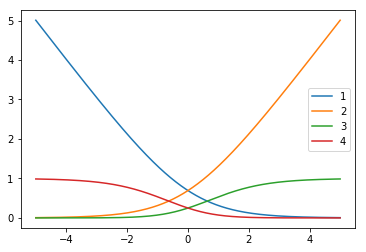

In [5]:
x = np.linspace(-5,5,1000)
plt.figure()
plt.plot(x, np.log(1+np.exp(-x)), label="1")
plt.plot(x, np.log(1+np.exp(x)), label="2")
plt.plot(x, 1./(1+np.exp(-x))**2, label="3")
plt.plot(x, 1./(1+np.exp(x))**2, label="4")
plt.legend(loc='best')
plt.show()